In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from sklearn.metrics import mean_squared_error

# Load your time series dataset
# Replace 'your_dataset.csv' with the actual file path or dataset loading method
df = pd.read_csv('Data/export_data.csv')
df.head()

2023-12-20 10:50:21.081471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 10:50:21.081506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 10:50:21.081538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 10:50:21.087452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Unnamed: 0,Coal_Quantity_MTon,Coal_Value_Lac,Petroleum_Quantity_MTon,Petroleum_Value_Lac,NaturalGas_Quantity_MTon,NaturalGas_Value_Lac
0,2018-01-31,4.31,52.51,7.56,249.11,14.88,470.39
1,2018-02-28,3.61,49.07,9.76,348.13,13.13,490.28
2,2018-03-31,4.19,59.32,9.26,392.26,12.01,431.05
3,2018-04-30,1.35,19.28,14.14,625.40,1.66,59.30
4,2018-05-31,4.64,62.61,14.57,642.49,3.31,138.96


In [2]:
# Assuming your dataset has a 'timestamp' column and multiple variables to predict
# Adjust column names accordingly

# Extract the target variables
data = df.iloc[:, 4].values

# Normalize the data
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)


In [3]:
# Function to create sequences for training the LSTM model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [4]:
# Set the sequence length (adjust as needed)
sequence_length = 10

# Create sequences and targets
X, y = create_sequences(data_normalized, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [5]:
# Build a more complex LSTM model for multivariate forecasting
model = Sequential()
model.add(LSTM(units=200, activation='relu', return_sequences=True, input_shape=(sequence_length, data.shape[1])))
model.add(Dropout(0.2))

model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=data.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error')


2023-12-20 10:50:23.495953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 10:50:23.514477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 10:50:23.514697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=3000, batch_size=32)


Epoch 1/3000


2023-12-20 10:50:26.235526: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff1245928c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 10:50:26.235546: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-12-20 10:50:26.239136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 10:50:26.263243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-20 10:50:26.310536: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 3s 28ms/step - loss: 0.1339
Epoch 2/3000
2/2 [==============================] - 0s 23ms/step - loss: 0.1215
Epoch 3/3000
2/2 [==============================] - 0s 23ms/step - loss: 0.1051
Epoch 4/3000
2/2 [==============================] - 0s 24ms/step - loss: 0.0861
Epoch 5/3000
2/2 [==============================] - 0s 24ms/step - loss: 0.0582
Epoch 6/3000
2/2 [==============================] - 0s 23ms/step - loss: 0.0471
Epoch 7/3000
2/2 [==============================] - 0s 23ms/step - loss: 0.0461
Epoch 8/3000
2/2 [==============================] - 0s 22ms/step - loss: 0.0480
Epoch 9/3000
2/2 [==============================] - 0s 31ms/step - loss: 0.0440
Epoch 10/3000
2/2 [==============================] - 0s 24ms/step - loss: 0.0407
Epoch 11/3000
2/2 [==============================] - 0s 24ms/step - loss: 0.0451
Epoch 12/3000
2/2 [==============================] - 0s 24ms/step - loss: 0.0468
Epoch 13/3000
2/2 [==============================]

In [7]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, data.shape[1]))


1/1 [==============================] - 0s 210ms/step


In [8]:
# Evaluate the model
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 629603.5239035723


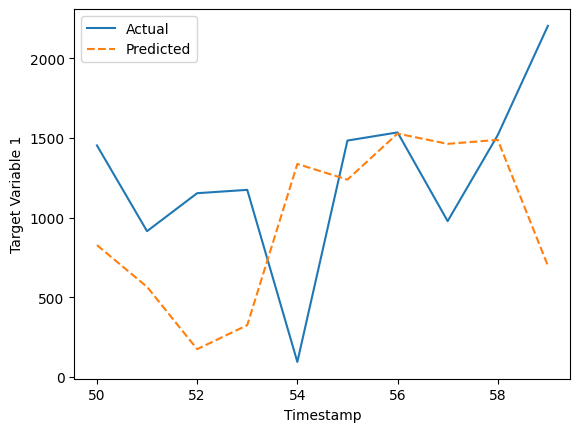

In [9]:
# Visualize the results for one of the target variables
plt.plot(df.index[-len(y_test_inv):], y_test_inv[:, 0], label='Actual')
plt.plot(df.index[-len(y_test_inv):], y_pred_inv[:, 0], label='Predicted', linestyle='dashed')
plt.xlabel('Timestamp')
plt.ylabel('Target Variable 1')
plt.legend()
plt.show()

In [10]:
model.save("working-predictor-v7.h5")

/home/darshk/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
